# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
# pip install catboost

In [2]:
# !pip install lightgbm

## 1.Загружаем библиотеки

In [3]:
import pandas as pd
import os
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np



from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score


from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV

from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor



import warnings
warnings.filterwarnings('ignore')

import os

from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_score, KFold
import time

from sklearn.dummy import DummyRegressor

## 2. Загрузка данных

In [4]:
pth1 = '/datasets/autos.csv'
pth2 = 'D:\DDownloads/autos.csv'

if os.path.exists(pth1):
    df = pd.read_csv(pth1)
elif os.path.exists(pth2):
    df = pd.read_csv(pth2)
else:
    print('Something is wrong')

In [5]:
df.head(6)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [7]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [8]:
# pandas_profiling.ProfileReport(df)

### Обзор данных:
- есть признаки которые неинформативны далее для модели, такие как DateCrawled, RegistrationMonth, DateCreated, NumberOfPictures, PostalCode и LastSeen. Удалим их
- есть 4 дубликата, удалим их
- price есть нулевые значения, удалим их
- power наблюдаем явные разбросы данных и нулевые значения, будим удалять
- RegistrationYear так же есть выбросы
- так же приведем название вколонок в верблюжий стиль
- gearbox 5% пропущенных значений, удалим их

In [9]:
df.sample(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
248425,2016-03-26 21:56:37,1900,convertible,1999,manual,110,mx_reihe,150000,4,petrol,mazda,no,2016-03-26 00:00:00,0,22880,2016-04-06 15:45:21
293570,2016-03-07 20:49:36,19200,bus,2015,manual,125,c_max,10000,7,petrol,ford,no,2016-03-07 00:00:00,0,50259,2016-04-05 17:45:35
149880,2016-03-14 19:37:37,1200,small,1999,auto,75,2_reihe,150000,6,petrol,peugeot,no,2016-03-14 00:00:00,0,75172,2016-03-16 11:45:12
327119,2016-03-21 17:45:46,3600,small,2005,manual,90,swift,125000,0,petrol,suzuki,NaN,2016-03-21 00:00:00,0,46562,2016-04-06 17:46:58
317842,2016-03-29 01:46:09,7500,sedan,2005,manual,131,a4,100000,12,petrol,audi,no,2016-03-20 00:00:00,0,61197,2016-04-06 17:44:45
212687,2016-04-04 12:45:05,2800,bus,2006,manual,105,meriva,150000,6,petrol,opel,no,2016-04-04 00:00:00,0,79843,2016-04-04 12:45:05
96215,2016-03-27 14:40:54,15490,suv,2012,auto,105,yeti,40000,9,petrol,skoda,no,2016-03-27 00:00:00,0,32049,2016-04-03 10:17:51
340081,2016-03-09 18:50:02,999,small,1999,manual,101,astra,60000,8,petrol,opel,yes,2016-03-09 00:00:00,0,14197,2016-03-11 02:45:32
38062,2016-03-10 21:48:55,4990,bus,2006,manual,140,golf,150000,10,gasoline,volkswagen,no,2016-03-10 00:00:00,0,12105,2016-04-06 22:15:48
266586,2016-04-04 19:48:02,450,NaN,2005,auto,144,carnival,150000,4,gasoline,kia,NaN,2016-04-04 00:00:00,0,45889,2016-04-06 22:16:29


In [10]:
df.duplicated().sum()

4

In [11]:
# удалим дубликаты
df = df.drop_duplicates()

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354365 non-null  object
 1   Price              354365 non-null  int64 
 2   VehicleType        316875 non-null  object
 3   RegistrationYear   354365 non-null  int64 
 4   Gearbox            334532 non-null  object
 5   Power              354365 non-null  int64 
 6   Model              334660 non-null  object
 7   Kilometer          354365 non-null  int64 
 8   RegistrationMonth  354365 non-null  int64 
 9   FuelType           321470 non-null  object
 10  Brand              354365 non-null  object
 11  Repaired           283211 non-null  object
 12  DateCreated        354365 non-null  object
 13  NumberOfPictures   354365 non-null  int64 
 14  PostalCode         354365 non-null  int64 
 15  LastSeen           354365 non-null  object
dtypes: int64(7), object(

In [13]:
df = df.drop(['RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   DateCrawled       354365 non-null  object
 1   Price             354365 non-null  int64 
 2   VehicleType       316875 non-null  object
 3   RegistrationYear  354365 non-null  int64 
 4   Gearbox           334532 non-null  object
 5   Power             354365 non-null  int64 
 6   Model             334660 non-null  object
 7   Kilometer         354365 non-null  int64 
 8   FuelType          321470 non-null  object
 9   Brand             354365 non-null  object
 10  Repaired          283211 non-null  object
dtypes: int64(4), object(7)
memory usage: 32.4+ MB


In [15]:
df.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'FuelType', 'Brand', 'Repaired'],
      dtype='object')

In [16]:
# приведим колонки в нижний регистр
df.columns = df.columns.str.lower()
df.columns

Index(['datecrawled', 'price', 'vehicletype', 'registrationyear', 'gearbox',
       'power', 'model', 'kilometer', 'fueltype', 'brand', 'repaired'],
      dtype='object')

In [17]:
# приведим колонки в змеиный стиль
df.columns = df.columns.str.replace('vehicletype', 'vehicle_type')
df.columns = df.columns.str.replace('registrationyear', 'registration_year')
df.columns = df.columns.str.replace('fueltype', 'fuel_type')
df.columns = df.columns.str.replace('repaired', 'is_repaired')
df.columns

Index(['datecrawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'fuel_type', 'brand', 'is_repaired'],
      dtype='object')

In [18]:
# смотрим пропуски
df.isna().sum()

datecrawled              0
price                    0
vehicle_type         37490
registration_year        0
gearbox              19833
power                    0
model                19705
kilometer                0
fuel_type            32895
brand                    0
is_repaired          71154
dtype: int64

##### vehicle_type

In [19]:
(df.vehicle_type.isna().sum() / len(df))*100

10.57948725184485

более 10% пропущенных значений, заменим пропуски заглушкой

In [20]:
df.vehicle_type.value_counts(dropna=False)

sedan          91457
small          79830
wagon          65165
NaN            37490
bus            28775
convertible    20203
coupe          16161
suv            11996
other           3288
Name: vehicle_type, dtype: int64

In [21]:
df['vehicle_type'] = df['vehicle_type'].fillna('unknown')
(df.vehicle_type.isna().sum() / len(df))*100

0.0

##### gearbox

In [23]:
df.gearbox.isna().sum()

19833

In [24]:
(df.gearbox.isna().sum() / len(df))*100

5.596771690206426

In [ ]:
df.mean()

In [22]:
df.gearbox.value_counts(dropna=False)

manual    268249
auto       66283
NaN        19833
Name: gearbox, dtype: int64

In [26]:
df.gearbox.unique()

array(['manual', 'auto', nan], dtype=object)

In [22]:
df['gearbox'] = df['gearbox'].fillna('unknown')
(df.gearbox.isna().sum() / len(df))*100

0.0

In [23]:
df.gearbox.value_counts()

manual     268249
auto        66283
unknown     19833
Name: gearbox, dtype: int64

##### model

In [24]:
(df.model.isna().sum() / len(df))*100

5.560650741467131

заменим пропуски заглушкой

In [25]:
df.model.value_counts(dropna=False)

golf                  29232
other                 24420
3er                   19761
NaN                   19705
polo                  13066
                      ...  
i3                        8
serie_3                   4
rangerover                4
range_rover_evoque        2
serie_1                   2
Name: model, Length: 251, dtype: int64

In [31]:
df.model.unique()

array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'meriva', 'arosa', 'c4', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'corsa', 'one',
       'fortwo', '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta',
       'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147',
       '100', 'z_reihe', 'sportage', 'sorento', 'v40', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'a3', 'almera', 'megane', 'lupo', 'r19',
       'zafira', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
       'vectra', 'berlingo', 'tiguan', 'i_reihe', 'espace', 'sharan',
       '6_reihe', 'panda', 'up', 'seicento', 'ceed', '5_reihe', 'yeti',
       'octavia', 'mii', 'rx_reihe', '6er', 'modus', 'fox'

In [30]:
df[df['model'] == '3_reihe']

,datecrawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,is_repaired
0,2016-03-24 11:52:17,480,unknown,1993,manual,0,3_reihe,150000,petrol,volkswagen,NaN
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,3_reihe,125000,gasoline,audi,yes
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,3_reihe,125000,gasoline,jeep,NaN
3,2016-03-17 16:54:04,1500,small,2001,manual,75,3_reihe,150000,petrol,volkswagen,no
4,2016-03-31 17:25:20,3600,small,2008,manual,69,3_reihe,90000,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,unknown,2005,manual,0,3_reihe,150000,petrol,mitsubishi,yes
354365,2016-03-14 17:48:27,2200,unknown,2005,unknown,0,3_reihe,20000,NaN,sonstige_autos,NaN
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,3_reihe,125000,petrol,smart,no
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,3_reihe,150000,gasoline,volkswagen,no


In [27]:
df['model'] = df['model'].fillna('unknown')
(df.gearbox.isna().sum() / len(df))*100

0.0

fuel_type

#### fuel_type

In [33]:
(df.fuel_type.isna().sum() / len(df))*100

9.282801631086592

In [34]:
df.fuel_type.unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

petrol and gasolinе одно и тоже, обьеденим их

In [31]:
df.fuel_type.value_counts(dropna=False)

petrol      216349
gasoline     98719
NaN          32895
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: fuel_type, dtype: int64

In [36]:
# Заменить "gasoline" на "petrol"
df['fuel_type'] = df['fuel_type'].replace('gasoline', 'petrol')
df.fuel_type.value_counts()

petrol      315068
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: fuel_type, dtype: int64

In [37]:
df['fuel_type'] = df['fuel_type'].fillna('unknown')

In [38]:
df.isna().sum()

datecrawled              0
price                    0
vehicle_type             0
registration_year        0
gearbox                  0
power                    0
model                    0
kilometer                0
fuel_type                0
brand                    0
is_repaired          71154
dtype: int64

In [39]:
df.columns

Index(['datecrawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'fuel_type', 'brand', 'is_repaired'],
      dtype='object')

##### is_repaired

In [40]:
df.is_repaired.isna().sum()

71154

In [41]:
(df.is_repaired.isna().sum() / len(df))*100

20.07929677027923

мое предположение, что если нет данных, то лучше заменить на заглушку

In [42]:
df['is_repaired'] = df['is_repaired'].fillna('unknown')

In [43]:
df.columns

Index(['datecrawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'fuel_type', 'brand', 'is_repaired'],
      dtype='object')

#### Аномалии в данных

##### price

In [44]:
df.price.value_counts()

0        10772
500       5670
1500      5394
1000      4648
1200      4594
         ...  
1368         1
233          1
11080        1
16340        1
10985        1
Name: price, Length: 3731, dtype: int64

In [45]:
#удалим 0 из целевого признака:
df = df.query('price > 0')

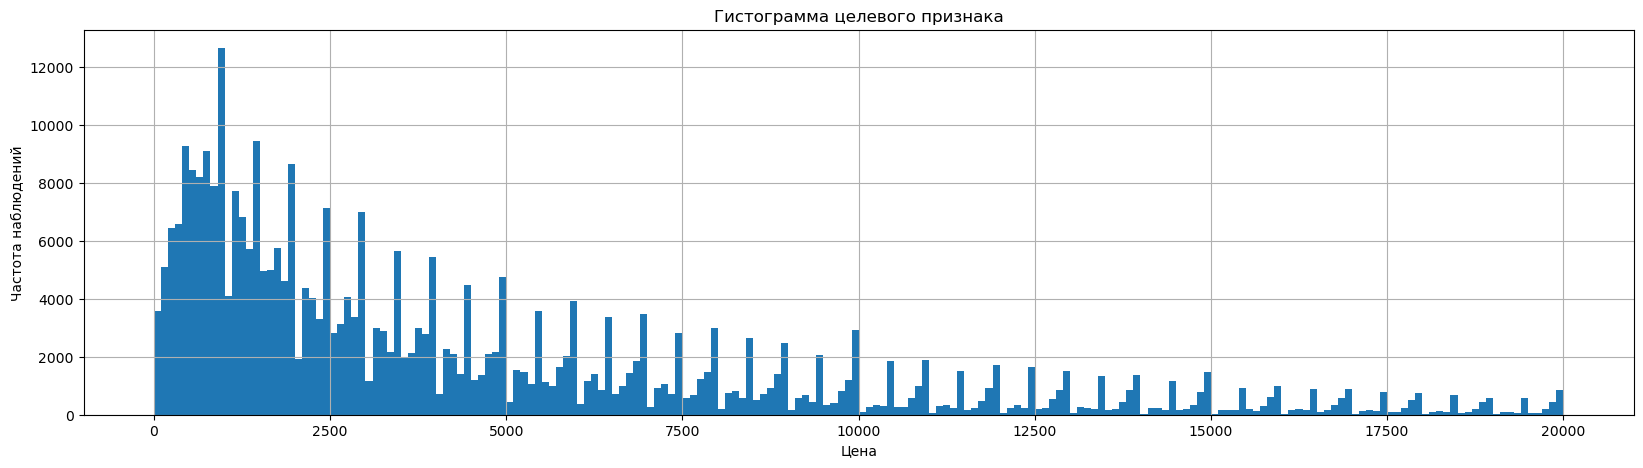

<Figure size 640x480 with 0 Axes>

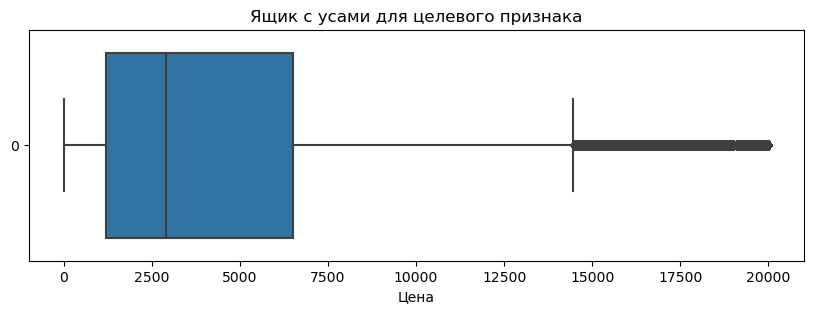

In [46]:
# Гистограмма
plt.figure(figsize=(20, 5))
df.price.hist(bins=200)
plt.xlabel('Цена')
plt.ylabel('Частота наблюдений')
plt.title('Гистограмма целевого признака')
plt.show()
plt.clf()  

# Ящик с усами
plt.figure(figsize=(10, 3))
sns.boxplot(data=df.price, orient='h')
plt.xlabel('Цена')
plt.title('Ящик с усами для целевого признака')
plt.show()


In [47]:
df.describe()

,price,registration_year,power,kilometer
count,343593.000000,343593.00000,343593.000000,343593.000000
mean,4555.147363,2004.08983,110.999665,128337.815380
std,4515.076200,78.41368,188.178919,37520.773792
min,1.000000,1000.00000,0.000000,5000.000000
25%,1200.000000,1999.00000,69.000000,125000.000000
50%,2890.000000,2003.00000,105.000000,150000.000000
75%,6500.000000,2008.00000,143.000000,150000.000000
max,20000.000000,9999.00000,20000.000000,150000.000000


In [48]:
df.price.describe()

count    343593.000000
mean       4555.147363
std        4515.076200
min           1.000000
25%        1200.000000
50%        2890.000000
75%        6500.000000
max       20000.000000
Name: price, dtype: float64

In [49]:
#посмотрим на квантили
df.price.quantile([.05, 0.95])

0.05      350.0
0.95    14800.0
Name: price, dtype: float64

95% значений находятся в диапазоне от 350 до 14800, остальные значения можно считать за выбросы, удалим их

In [50]:
#округлю до 15к
df = df.query('350 <= price <= 15000')

In [51]:
df.price.describe()

count    313143.000000
mean       4158.695660
std        3639.581202
min         350.000000
25%        1300.000000
50%        2899.000000
75%        6000.000000
max       15000.000000
Name: price, dtype: float64

##### registration_year

In [52]:
df.registration_year.describe()

count    313143.000000
mean       2003.772235
std          65.672258
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        9999.000000
Name: registration_year, dtype: float64

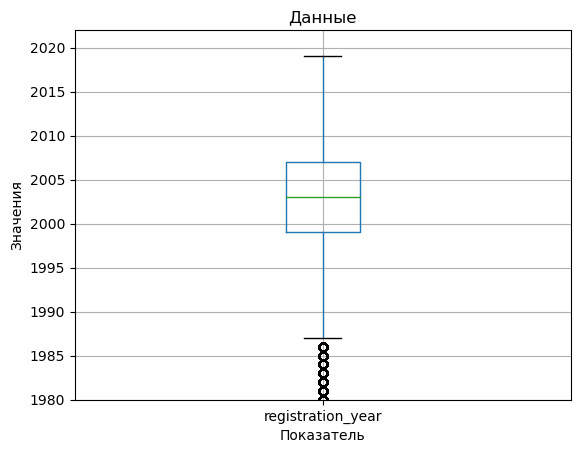

In [53]:
# визуализируем данные 
plt.title('Данные')
df[['registration_year']].boxplot()
plt.ylim(1980,2022)
plt.ylabel('Значения')
plt.xlabel('Показатель')
plt.show()

In [54]:
df.registration_year.value_counts().tail(50)

7000    3
1941    2
1934    2
2500    2
1943    2
1928    2
5555    2
1600    2
1923    2
1936    2
1935    2
1942    2
1932    2
3000    2
1500    2
4500    2
1234    2
9000    2
5911    2
1940    2
4000    2
1111    1
1602    1
1931    1
7800    1
7100    1
1300    1
1948    1
8200    1
1039    1
2800    1
2290    1
1944    1
9450    1
5300    1
2900    1
8888    1
3200    1
1400    1
1949    1
2066    1
8500    1
1925    1
3700    1
3800    1
4800    1
4100    1
1930    1
1001    1
1946    1
Name: registration_year, dtype: int64

построим гистограмму распределения registration_year

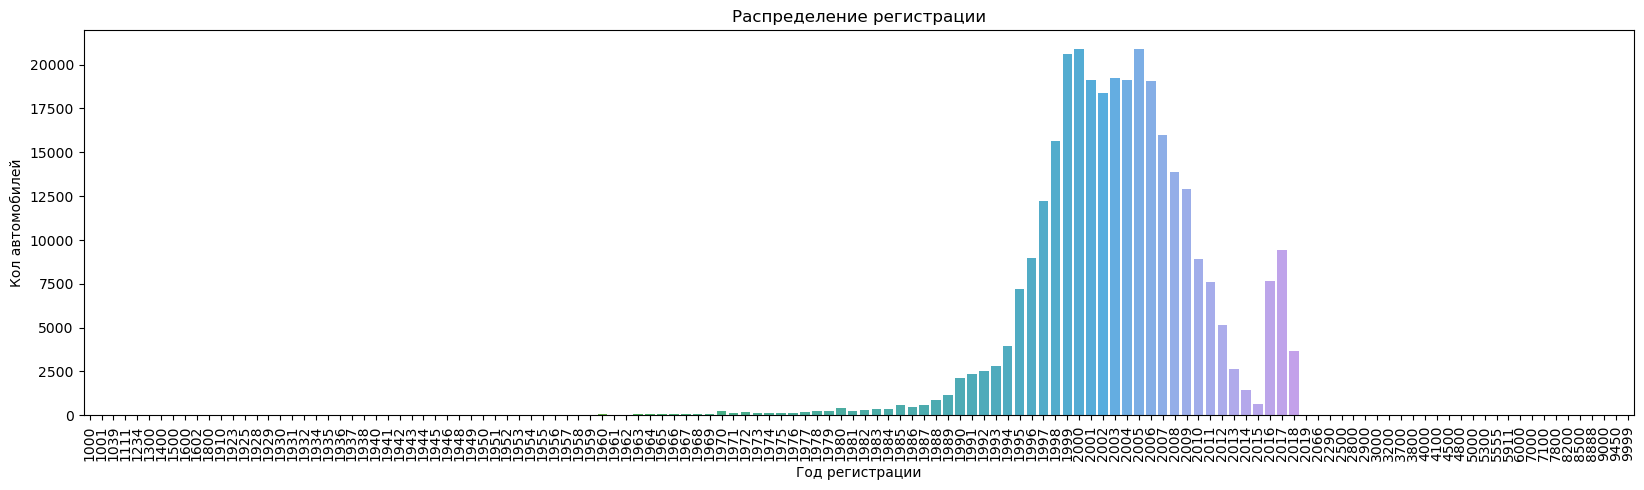

In [55]:
# Группировка по годам регистрации и подсчет количества автомобилей
annual = df.groupby('registration_year')['brand'].count().reset_index()
annual.columns = ['registration_year', 'quantity']

# Построение графика с использованием seaborn
plt.figure(figsize=(20, 5))
sns.barplot(x='registration_year', y='quantity', data=annual)
plt.title('Распределение регистрации')
plt.xlabel('Год регистрации')
plt.ylabel('Кол автомобилей')
plt.xticks(rotation=90)  # Поворот значений на оси X на 90 градусов
plt.show()

In [56]:
df[df['registration_year']<1980].shape[0]

2632

In [57]:
df['registration_year'].shape[0]

313143

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 313143 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   datecrawled        313143 non-null  object
 1   price              313143 non-null  int64 
 2   vehicle_type       313143 non-null  object
 3   registration_year  313143 non-null  int64 
 4   gearbox            313143 non-null  object
 5   power              313143 non-null  int64 
 6   model              313143 non-null  object
 7   kilometer          313143 non-null  int64 
 8   fuel_type          313143 non-null  object
 9   brand              313143 non-null  object
 10  is_repaired        313143 non-null  object
dtypes: int64(4), object(7)
memory usage: 28.7+ MB


In [59]:
df.datecrawled

0         2016-03-24 11:52:17
2         2016-03-14 12:52:21
3         2016-03-17 16:54:04
4         2016-03-31 17:25:20
5         2016-04-04 17:36:23
                 ...         
354363    2016-03-27 20:36:20
354365    2016-03-14 17:48:27
354366    2016-03-05 19:56:21
354367    2016-03-19 18:57:12
354368    2016-03-20 19:41:08
Name: datecrawled, Length: 313143, dtype: object

In [60]:
df['datecrawled'] = pd.to_datetime(df['datecrawled'])
df

,datecrawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,is_repaired
0,2016-03-24 11:52:17,480,unknown,1993,manual,0,golf,150000,petrol,volkswagen,unknown
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,petrol,jeep,unknown
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,petrol,skoda,no
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
...,...,...,...,...,...,...,...,...,...,...,...
354363,2016-03-27 20:36:20,1150,bus,2000,manual,0,zafira,150000,petrol,opel,no
354365,2016-03-14 17:48:27,2200,unknown,2005,unknown,0,unknown,20000,unknown,sonstige_autos,unknown
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,petrol,volkswagen,no


In [61]:
df['datecrawled'].nlargest()

90713    2016-04-07 14:36:58
339649   2016-04-07 14:36:56
53739    2016-04-07 14:36:54
204218   2016-04-07 14:36:53
304465   2016-04-07 14:36:46
Name: datecrawled, dtype: datetime64[ns]

последняя дата выгружки 04/072017, это и будет нашим верхей границей

In [62]:
# удалим выбросы
df = df[(df['registration_year']>1970)&(df['registration_year']<2017)]

In [63]:
df['registration_year'].shape[0]

298862

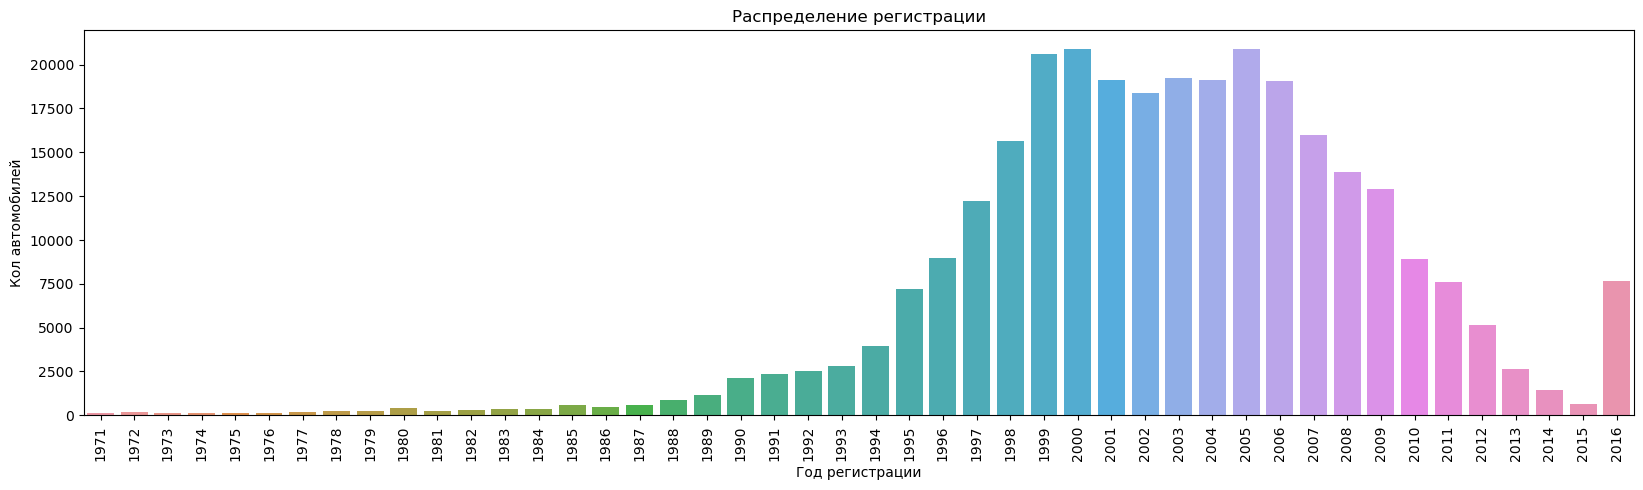

In [64]:
# Группировка по годам регистрации и подсчет количества автомобилей
annual = df.groupby('registration_year')['brand'].count().reset_index()
annual.columns = ['registration_year', 'quantity']

# Построение графика с использованием seaborn
plt.figure(figsize=(20, 5))
sns.barplot(x='registration_year', y='quantity', data=annual)
plt.title('Распределение регистрации')
plt.xlabel('Год регистрации')
plt.ylabel('Кол автомобилей')
plt.xticks(rotation=90)  # Поворот значений на оси X на 90 градусов
plt.show()

In [65]:
df['registration_year'].shape[0]

298862

In [66]:
df.columns

Index(['datecrawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'fuel_type', 'brand', 'is_repaired'],
      dtype='object')

мы удалили 14 281 строк

In [67]:
#удалим колонку 
df.drop('datecrawled', axis=1, inplace=True)

In [68]:
df.power.describe()

count    298862.000000
mean        111.396524
std         183.887878
min           0.000000
25%          75.000000
50%         105.000000
75%         140.000000
max       20000.000000
Name: power, dtype: float64

In [69]:
np.percentile(df['power'], 95)

211.0

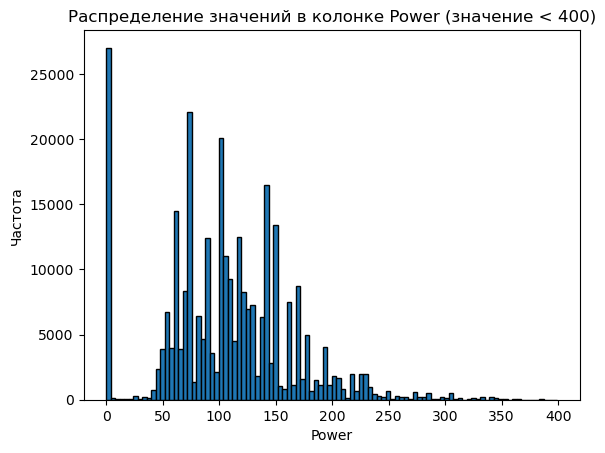

In [70]:
# Создание отдельной Series для столбца 'Power', где значение < 250
filtered_power = df[df['power'] < 400]['power']

# Построение гистограммы для отфильтрованных значений 'Power'
plt.hist(filtered_power, bins=100, edgecolor='k')  # Вы можете изменить количество "bins" по своему усмотрению
plt.xlabel('Power')
plt.ylabel('Частота')
plt.title('Распределение значений в колонке Power (значение < 400)')
plt.show()

согалсно вики самая мощная тс для ритейла это Lotus Evija 1500 лс, но врядли такие авто есть на рынке поддержанных машин, так что ограничемся знаечнием в 300 лс.
а самые моломщные это трехколесный Peel P50 с 4,2 лс.
ограничемся этими знаечнями

In [71]:
# # # посмотрим количество выбросов Power
len(df[['power']][(df['power'] < 4.2) | (df['power'] > 300)])

29370

In [72]:
# # удалим выбросы Power
df = df.query('4.2 <= power <= 300')

In [73]:
df.sample(5)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,is_repaired
278024,1111,wagon,2000,manual,116,zafira,150000,petrol,opel,no
193110,12350,sedan,2007,auto,184,c_klasse,100000,petrol,mercedes_benz,no
72754,700,unknown,2016,auto,207,laguna,150000,unknown,renault,unknown
38165,1100,sedan,1999,manual,106,astra,150000,petrol,opel,no
281510,2999,suv,1992,manual,150,pajero,125000,petrol,mitsubishi,unknown


In [74]:
df.kilometer.describe()

count    269492.000000
mean     129945.601354
std       35150.866090
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: kilometer, dtype: float64

большинство авто имеют пробег 15к, возможно это ограничение сайта, оставим как есть

## 3. Подготовьте выборки для обучения моделей.

In [75]:
# Выделяем признаки и целевой признак
features_orig = df.drop('price', axis=1)
target = df.price

# Разделяем на выборки
features_train, features_test, target_train, target_test = train_test_split(features_orig,
                                                                            target, 
                                                                            test_size=.25,
                                                                            random_state=12345)

# Определяем списки категориальных и числовых признаков
categorical_features = ['vehicle_type', 'fuel_type', 'brand', 'model']
numerical_features = ['registration_year', 'power', 'kilometer']

## 4.Обучение моделей

### 4.1. Модель LinearRegression

#### 4.1.3. C использованием кроссвалидации

In [76]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

#Создаем экземпляр класса OneHotEncoder для кодирования категориальных признаков
encoder = OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore')


# Определяем преобразователи для числовых и категориальных признаков
preprocessor = ColumnTransformer(
    transformers=[
        ('num', scaler, numerical_features),
        ('cat', encoder, categorical_features)
    ])

# Создаем конвейер с преобразованиями и моделью
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

#Обучаем модель с помощью кросс-валидации
start_time_cv = time.time()
scores = cross_val_score(pipeline, features_train, target_train, cv=5, scoring='neg_mean_squared_error')
end_time_cv = time.time()

#Вычисляем среднее значение RMSE по кросс-валидации
rmse_lr_ohe_cv = (np.sqrt(-scores)).mean()

#Время кросс-валидации в минутах
lr_cv_time = (end_time_cv - start_time_cv) 


rmse_lr_ohe_cv

2138.94278605423

In [77]:
#Обучаем отдельный экземпляр модели на всем тренировочном наборе данных
start_time_train = time.time()
pipeline.fit(features_train, target_train)
end_time_train = time.time()



#Время обучения модели на всем тренировочном наборе данных в минутах
LR_model_ohe_time_cv = (end_time_train - start_time_train) 

# Предсказание на тренеровочном наборе данных и замер времени предсказания
start_time = time.time()
target_predict = pipeline.predict(features_train)
end_time = time.time()

# Вычисление времени предсказания в секундах
LR_ohe_prediction_cv = end_time - start_time

#Вывод результатов
print("Среднее значение RMSE (кросс-валидация):", rmse_lr_ohe_cv)
print("Время кросс-валидации (сек):", lr_cv_time)
print("Время обучения модели на всем тренировочном наборе данных (сек):", LR_model_ohe_time_cv)
print("Время предсказания(сек):", LR_ohe_prediction_cv)


Среднее значение RMSE (кросс-валидация): 2138.94278605423
Время кросс-валидации (сек): 18.26806378364563
Время обучения модели на всем тренировочном наборе данных (сек): 4.44333553314209
Время предсказания(сек): 0.7040538787841797


### 4.2. Модель CatBoostRegressor

#### 4.2.1. Обучение модели CatBoostRegressor с CV и подбором гиперпараметров

In [78]:
# Создаем экземпляр класса OrdinalEncoder для кодирования категориальных признаков
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

# Определяем преобразователи для числовых и категориальных признаков
preprocessor = ColumnTransformer(
    transformers=[
        ('num', scaler, numerical_features),
        ('cat', encoder, categorical_features)
    ])

# Создаем конвейер с преобразованиями и моделью
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', CatBoostRegressor(random_state=12345, verbose=False))
])

# Определяем сетку гиперпараметров для поиска
param_grid = {
    'model__learning_rate': [0.01, 0.05, 0.1, 0.5],
    'model__depth': [4, 6, 8, 10],
    'model__iterations': [100, 200, 300]
}
# Кросс-валидация с 5 фолдами 
grid_search = GridSearchCV(pipeline, param_grid, scoring='neg_mean_squared_error', cv=5)
start_time = time.time()
grid_search.fit(features_orig, target)
end_time = time.time()

# лучшие гиперпараметрыии  лучшие оценки RMSE
best_params = grid_search.best_params_
best_rmse = (-grid_search.best_score_) ** 0.5

# определяем время
grid_search_time = end_time - start_time

# Измерение времени предсказания на всем наборе данных
start_time = time.time()
predictions = grid_search.best_estimator_.predict(features_orig)
end_time = time.time()

# время предсказания в секундах
prediction_time_bp = end_time - start_time


# выводим результаты
print("лучшие гиперпараметры:", best_params)
print("лучшее RMSE с cross-validation:", best_rmse)
print("Grid search time (сек):", grid_search_time)
print("Время предсказания модели (сек):", prediction_time_bp)


лучшие гиперпараметры: {'model__depth': 10, 'model__iterations': 300, 'model__learning_rate': 0.5}
лучшее RMSE с cross-validation: 1375.7910288254345
Grid search time (сек): 1640.8797392845154
Время предсказания модели (сек): 1.1993579864501953


In [79]:
from sklearn.pipeline import make_pipeline

# лучшие гиперпараметры
best_params = grid_search.best_params_

# создаем пайплайн с лучшими гиперпараметрами
best_pipeline = make_pipeline(
    ColumnTransformer(
        transformers=[
            ('num', scaler, numerical_features),
            ('cat', encoder, categorical_features)
        ]
    ),
    CatBoostRegressor(learning_rate=best_params['model__learning_rate'],
                      depth=best_params['model__depth'],
                      iterations=best_params['model__iterations'],
                      random_state=12345, verbose=False)
)

# измеряем время лучшей модели
start_time_train_best = time.time()
best_pipeline.fit(features_orig, target)
end_time_train_best = time.time()

# время в сек
best_model_train_time = end_time_train_best - start_time_train_best

# вывод резульаттов
print("лучшие гиперпараметры:", best_params)
print("время обучения лучшей модели в сек:", best_model_train_time)

лучшие гиперпараметры: {'model__depth': 10, 'model__iterations': 300, 'model__learning_rate': 0.5}
время обучения лучшей модели в сек: 16.035647869110107


### 4.3. Модель LightGBMRegressor

#### 4.3.1 На выборках c CV

In [80]:
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict

# Создаем экземпляр класса StandardScaler для масштабирования числовых признаков
scaler = StandardScaler()

# Создаем экземпляр класса OrdinalEncoder для кодирования категориальных признаков
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

# Определяем преобразователи для числовых и категориальных признаков
preprocessor = ColumnTransformer(
    transformers=[
        ('num', scaler, numerical_features),
        ('cat', encoder, categorical_features)
    ])

# Создаем конвейер с преобразованиями и моделью
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LGBMRegressor(random_state=12345))
])

# Кросс-валидация с 5 фолдами и предсказание 
start_time = time.time()
target_predict_cv = cross_val_predict(pipeline, features_train, target_train, cv=5)
end_time = time.time()

# Вычисляем среднее значение RMSE по кросс-валидации
rmse_lgbmr_cv = mean_squared_error(target_train, target_predict_cv) ** 0.5

# Вычисляем время обучения модели без кросс-валидации
start_time_fit = time.time()
pipeline.fit(features_train, target_train)
end_time_fit = time.time()

LGBM_model_cv_time = end_time_fit - start_time_fit

# Делаем предсказания на тестовых данных
start_time_predict = time.time()
target_predict = pipeline.predict(features_train)
end_time_predict = time.time()

LGBM_cv_prediction = end_time_predict - start_time_predict

# Оцениваем качество модели на тестовых данных

print("RMSE (кросс-валидация):", rmse_lgbmr_cv)
print("Время обучения модели (без кросс-валидации, сек):", LGBM_model_cv_time)
print("Время предсказания модели (сек):", LGBM_cv_prediction)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002240 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 573
[LightGBM] [Info] Number of data points in the train set: 161695, number of used features: 7
[LightGBM] [Info] Start training from score 4309.535218
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002142 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 575
[LightGBM] [Info] Number of data points in the train set: 161695, number of used features: 7
[LightGBM] [Info] Start training from score 4310.689378
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002293 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory

#### Промежуточный вовыд:
Обучили три модели - линейную регрессию, CatBoostRegressor и LGBMRegressor. использывал пайлпайны.

 Теперь сделаю финальный вывод и выберу наилучшую модель из тех, которые показали хорошие результаты, учитываю метрику, время обучения и предсказание.

## Анализ моделей

## 5. Выбор лучшей модели и ее тестирование

In [81]:
#создаю сводную таблицу по показателям, время обучения модели и время предсказания модели:
index = ['LGBMRegressor с CV',
         'Линейная регрессия с CV',
          
         'CatBoostRegressor с лучш. гиперпар',
         
        ]

data = {'RMSE':[rmse_lgbmr_cv,
                rmse_lr_ohe_cv,
               
                best_rmse,
                ],
        
        'Время обучения модели':[LGBM_model_cv_time,
                                 LR_model_ohe_time_cv,
                                 
                                 best_model_train_time,
                                 ],
        
        'Время предсказания модели':[LGBM_cv_prediction,
                                    LR_ohe_prediction_cv,
                                   
                                    prediction_time_bp,
                                    ]
       }

kpi_data = pd.DataFrame(data=data, index=index)

kpi_data['Время обучения модели'] = kpi_data['Время обучения модели'].replace('NA', 0).astype(float)
kpi_data['Время предсказания модели'] = kpi_data['Время предсказания модели'].replace('NA', 0).astype(float)

#ввожу столбец Рейтинг с весами:
kpi_data['Рейтинг'] = (kpi_data['RMSE'] * .34 \
                       + kpi_data['Время обучения модели'] * .33 \
                       + kpi_data['Время предсказания модели'] * .33)

kpi_data.sort_values(by = 'Рейтинг', ascending=True)

,RMSE,Время обучения модели,Время предсказания модели,Рейтинг
CatBoostRegressor с лучш. гиперпар,1375.791029,16.035648,1.199358,473.456502
LGBMRegressor с CV,1475.230665,1.055081,0.709054,502.160590
Линейная регрессия с CV,2138.942786,4.443336,0.704054,728.939186


Модель CatBoostRegressor с CV с лучшими гиперпараметрами демонстрирует наилучший результат RMSE и является предпочтительной. Модель LinearRegression  имеет наихудший рейтинг.

## 6. Опираясь на критерии заказчика, выберете лучшую модель, проверьте её качество на тестовой выборке.

проверим нашу лучшую модель с лучшими гиперпараметарми на тестовой выборке

In [82]:
# Делаем предсказания и замеряем время предсказания на тестовых данных
start_time = time.time()
target_predict = best_pipeline.predict(features_test)
end_time = time.time()

# Вычисляем время предсказания в секундах
bm_prediction_time = end_time - start_time

# Вычисляем RMSE на тестовых данных
bm_rmse = mean_squared_error(target_test, target_predict, squared=False)

# Выводим результаты
print("Время обучения модели (сек):", best_model_train_time)
print("Время предсказания модели (сек):", bm_prediction_time)
print("RMSE на тестовых данных:", bm_rmse)

Время обучения модели (сек): 16.035647869110107
Время предсказания модели (сек): 0.37502622604370117
RMSE на тестовых данных: 1227.1279528589114


довольно  достойный результат

### Сравниваем с Константной моделью

In [83]:
# Создаем экземпляр DummyRegressor с заданной стратегией
dummy_model = DummyRegressor(strategy="mean")  # Используйте нужную стратегию: "mean", "median" или "constant"

# Обучение модели DummyRegressor
dummy_model.fit(features_train, target_train)

# Предсказание на тестовых данных
target_predict_dummy = dummy_model.predict(features_test)

# Оценка производительности модели DummyRegressor
rmse_dummy = mean_squared_error(target_test, target_predict_dummy) ** 0.5
print("RMSE для DummyRegressor:", rmse_dummy)


RMSE для DummyRegressor: 3686.1452845617396


как видим что эта простая константная модель, которая всегда предсказывает среднее значение целевой переменной, имеет достаточно высокую ошибку предсказания, в три раза чем наша лучшая модель

### Финальный Вывод:
В процессе выполнения проекта, я загрузил данные и провел их предобработку, включая очистку, заполнение пропущенных значений и удаление лишних данных. Затем я провел сравнительный анализ трех моделей с разными гиперпараметрами и выборками данных. После анализа, я выбрал лучшую модель, основываясь на трех критериях - RMSE, время обучения и время предсказания. Это позволило мне определить CatBoostRegressor с CV  с лучшими гиперпараметрами как наилучшую модель. После этого, на тестовой выборке узнали  ее вемя обучения и предсказания. Так же сравнивая ее с контантной моделью DummyRegressor, мы можем видеть что наша лучшая модель имеет значительно более низкую ошибку, что делает ее более эффективным.( 1227 vs 3686 rmse)